In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# prompt: to /content/drive/MyDrive/Driving_License_OCR-main file
%cd /content/drive/MyDrive/Driving_License_OCR-main-v2

Mounted at /content/drive
/content/drive/MyDrive/Driving_License_OCR-main-v2


In [ ]:
!pip install ultralytics # install the ultralytics package
!pip install pdf2image # install the pdf2image package
!pip install whatimage # install the whatimage package
!pip install wand # install the wand package
!apt-get install libmagickwand-dev
import os
import warnings
warnings.filterwarnings('ignore')
from ultralytics import YOLO
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import torch
import pandas as pd
from tqdm import tqdm
from reader import text_extraction
from preprocessing import get_position, get_type, folder_scanner, pdftoimg, img_files, rotation, get_state

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.9/871.9 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 2.6 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gir1.2-freedesktop
  gir1.2-gdkpixbuf-2.0 gir1.2-rsvg-2.0 gsfonts imagemagick-6-common libblkid-dev libblkid1
  libcairo-script-interpreter2 libcairo2-dev libdjvulibre-dev libdjvulibre-text libdjvulibre21
  libffi-dev libfftw3-double3 libgdk-pixbuf-2.0-dev libgdk-pixbuf2.0-bin libglib2.0-dev
  libglib2.0-dev-bin libgs9 libgs9-common libice-dev libidn12 libijs-0.35 libjbig2dec0 libjxr-tools
  libjxr0 liblcms2-dev liblqr-1-0 liblqr-1-0-dev liblzo2-2 libmagickcore-6-arch-config
  libmagickcore-6-headers libmagickcore-6.q16-6 libmagickcore

In [ ]:
# Load processor and model
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')
trocr_model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed')

# Use GPU if availabl
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trocr_model.to(device)

# Load other models (assuming they are in .pt format)
rotate_model = torch.load(r'/content/drive/MyDrive/Driving_License_OCR-main-v2/resnet/rotate_entire_2.pt', map_location=device)
class_model = torch.load(r'/content/drive/MyDrive/Driving_License_OCR-main-v2/resnet/class_entire_2.pt', map_location=device)
model = YOLO(r'/content/drive/MyDrive/Driving_License_OCR-main-v2/weights/best.pt')  # Assuming YOLO model handles device assignment
state_model = torch.load(r'/content/drive/MyDrive/Driving_License_OCR-main-v2/resnet/state_class_2.pt', map_location=device)

preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
device

device(type='cpu')

In [ ]:
home = r'/content/drive/MyDrive/Driving_License_OCR-main-v2/demo'
images = img_files(folder_scanner(home))
images

['/content/drive/MyDrive/Driving_License_OCR-main-v2/demo/DL-F.jpg',
 '/content/drive/MyDrive/Driving_License_OCR-main-v2/demo/1.jpeg',
 '/content/drive/MyDrive/Driving_License_OCR-main-v2/demo/3.jpeg',
 '/content/drive/MyDrive/Driving_License_OCR-main-v2/demo/2.jpeg']

In [ ]:
from google.colab import files
import shutil
import os

home = r'/content/drive/MyDrive/Driving_License_OCR-main-v2/demo'

# 1. Upload files using files.upload()
uploaded = files.upload()

# 2. Move uploaded files to the 'demo' folder
if uploaded:
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
    # Move the uploaded file to the desired directory
    shutil.move(name, home)
    print(f'{name} uploaded and moved to {home}')

# 3. (Optional) List files in 'demo' folder
images = os.listdir(home)
print(f"Files in {home}: {images}")

# Now you can use the 'images' list in your 'img_files' and 'folder_scanner' functions
# ... your existing code to process images ...

Saving 3.jpeg to 3 (1).jpeg
3 (1).jpeg uploaded and moved to /content/drive/MyDrive/Driving_License_OCR-main/demo
Files in /content/drive/MyDrive/Driving_License_OCR-main/demo: ['3 (1).jpeg', '2.jpeg', '1.jpeg', '3.jpeg', 'DL-F.jpg']


In [ ]:
dfs = pd.DataFrame()

for file in tqdm(images):
    class_model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    data = text_extraction(file, class_model, model, processor, trocr_model,rotate_model)
    if isinstance(data, pd.DataFrame):
        # Move the model to the appropriate device based on GPU availability
        state_model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        data['State']=get_state(state_model, file)
        dfs = pd.concat([dfs, data], ignore_index=True)

100%|██████████| 4/4 [12:06<00:00, 181.54s/it]


In [ ]:
dfs

,Address,Class,DOB,Exp date,First name,Issue date,Last name,License number,Sex,Folder,State
0,"T621 81ST ST -\nBROOKLYN, NY 11214",D,05/07/1987,05/07/2029,FANGQIN,08/21/2024,ZHAO,915 821 245,M,demo,New York
1,"20605 PEACEFUL WOODS DR\nDIAMOND BAR, CA 91789",C,02/11/1992,02/11/2029,JIAHUI,02/08/2024,JIAHUI,Y7842919,F,demo,California
2,"617 60TH ST @\nBROOKLYN, NY 11220",D,10/04/1991,10/04/2028,LINGJIE,01/25/2024,WANG,549 202 684,M,demo,New York
3,"881 57TH ST FL 1\nBROOKLYN, NY 11220",D,10/23/1971,10/23/2028,CHAOYU,03/13/2024,ZHENG,952 962 112,M,demo,New York


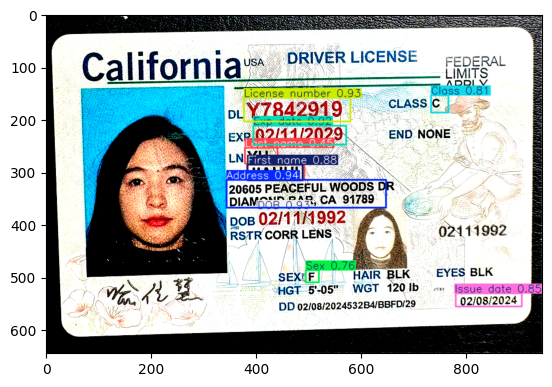

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Move the model to the appropriate device before using it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rotate_model.to(device)

img = rotation(rotate_model, r'C:\Users\Union\Downloads\photo_2024-09-10_15-29-32.jpg')
# Enhance contrast to make text more prominent
enhancer = ImageEnhance.Contrast(img)
img = enhancer.enhance(2)# Experiment with different values (1.5, 2, etc.)
results = model.predict(source=img, augment=True, verbose=False)
for r in results:
    im_array = r.plot()
    im = Image.fromarray(im_array[..., ::-1])
    plt.imshow(im)

In [ ]:
from reader import read_img
read_img(img, model, processor, trocr_model)

{'Address': ['3045 PATTILANE\nLANCASTER, CA 93535'],
 'Class': ['C'],
 'DOB': ['02/01/1995'],
 'Exp date': ['02/01/2023'],
 'First name': ['IDINSTATE MIDDLE'],
 'Issue date': ['06/28/2018'],
 'Last name': ['ADAMS'],
 'License number': ['B5568240'],
 'Sex': ['F']}

# **Testng !!!**

In [ ]:
def read_img_ad(dl_image, model, processor, trocr_model):
    """Detects labels on a Driver's License (DL) image and recognizes text within them.

    Parameters
    ----------
    dl_image : PIL.Image.Image
        The driver's license image.
    model : YOLO trained model
        The model for object detection.
    processor : TrOCRProcessor
        The processor for text recognition.
    trocr_model : VisionEncoderDecoderModel
        The model for text recognition.

    Returns
    -------
    dict
        A dictionary containing recognized text grouped by labels.
    """
    results = model.predict(source=dl_image, augment=True, verbose=False)
    labels = ['Address', 'Class', 'DOB', 'Exp date', 'First name', 'Issue date', 'Last name', 'License number', 'Sex']
    boxes = results[0].boxes
    data = {key: [] for key in labels}
    preds = {int(box.cls): [] for box in boxes}

    i = -1
    for bounding_box in boxes:
        i += 1
        if bounding_box.conf[0] < 0.6:
            continue
        preds[int(bounding_box.cls)].append((float(bounding_box.conf[0]), i))

    # Function to process the cropped image using TrOCR
    def process_image(img):
        pixel_values = processor(images=img, return_tensors="pt").pixel_values
        generated_ids = trocr_model.generate(
            pixel_values,
            num_beams=5,  # Beam search to improve text accuracy
            max_new_tokens=200,  # Adjust for the expected text length
            early_stopping=True  # Stops when a reasonable text sequence is detected
        )
        return processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    for key, value in preds.items():
        idx = max(value, key=lambda x: x[0])[1]
        bounding_box = boxes[idx]
        x1, y1, x2, y2 = bounding_box.xyxy[0].tolist()
        crop_img = dl_image.crop((x1, y1, x2, y2)).convert("RGB")

        # Optional: Resize the cropped image for better OCR performance
        crop_img = crop_img.resize((crop_img.width * 4, crop_img.height * 4))

        # Check if this is a label like 'Address' that could have multiple lines
        if labels[int(bounding_box.cls)] == 'Address':
            # Split the image into two parts if it's an address
            width, height = crop_img.size
            half_height = height // 2

            # Crop the top part (e.g., street address)
            img_top = crop_img.crop((0, 0, width, half_height))

            # Crop the bottom part (e.g., city and ZIP code)
            img_bottom = crop_img.crop((0, half_height, width, height))

            # Process the top and bottom images separately
            text_top = process_image(img_top)
            text_bottom = process_image(img_bottom)

            # Combine the results
            generated_text = text_top + "\n" + text_bottom
        else:
            # For other labels, process the entire cropped image directly
            generated_text = process_image(crop_img)

        # Append the recognized text to the corresponding label
        data[labels[int(bounding_box.cls)]].append(generated_text)

    return data


In [ ]:
read_img_ad(img, model, processor, trocr_model)

{'Address': ['617 60TH ST @\nBROOKLYN, NY 11220'],
 'Class': ['D'],
 'DOB': ['10/04/1991'],
 'Exp date': ['10/04/2028'],
 'First name': ['LINGJIE'],
 'Issue date': ['01/25/2024'],
 'Last name': ['WANG'],
 'License number': ['549 202 684'],
 'Sex': ['M']}

In [ ]:
results = model.predict(source=img, augment=True, verbose=False)
labels = ['Address', 'Class', 'DOB', 'Exp date', 'First name', 'Issue date', 'Last name', 'License number', 'Sex']
boxes = results[0].boxes
data = {key: [] for key in labels}
preds = {int(box.cls):[] for box in boxes}

i = -1
for bounding_box in boxes:
    i+=1
    if bounding_box.conf[0]<0.1:
        continue
    preds[int(bounding_box.cls)].append((float(bounding_box.conf[0]), i))

In [ ]:
preds

{0: [(0.9361295104026794, 0)],
 2: [(0.9337000846862793, 1)],
 7: [(0.9294308423995972, 2)],
 3: [(0.9231529831886292, 3)],
 4: [(0.8819204568862915, 4)],
 5: [(0.8537349104881287, 5)],
 1: [(0.8141607046127319, 6)],
 8: [(0.7564252614974976, 7)],
 6: [(0.4771447777748108, 8), (0.44762009382247925, 9)]}

344.0919189453125 315.9244079589844 648.3668212890625 368.0226135253906


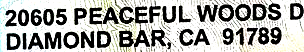

403.9223327636719 372.7371520996094 573.5973510742188 404.7667236328125


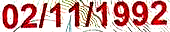

377.25103759765625 159.2763214111328 580.83447265625 204.2661590576172


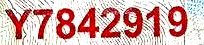

395.1828308105469 212.1453399658203 572.209228515625 248.17666625976562


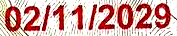

384.4176025390625 286.35992431640625 489.8638610839844 316.28057861328125


781.8379516601562 531.9097900390625 907.2151489257812 556.187255859375


734.1785888671875 154.41696166992188 767.7529907226562 187.339111328125


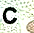

495.2770080566406 487.6268005371094 520.7102661132812 510.9693603515625


383.2591247558594 286.5802001953125 492.86871337890625 315.76568603515625


In [ ]:
cropped_images = []

for key, value in preds.items():
    idx = max(value, key=lambda x: x[0])[1]
    bounding_box = boxes[idx]
    x1, y1, x2, y2 = bounding_box.xyxy[0].tolist()
    print(x1, y1, x2, y2)
    crop_img = img.crop((x1, y1, x2, y2)).convert("RGB")
    display(crop_img)
    crop_img = crop_img.resize((crop_img.width * 4, crop_img.height * 4))

    cropped_images.append(crop_img)

# Now cropped_images contains all the cropped images


In [ ]:
img.crop((x1, y1, x2, y2)).convert("RGB")

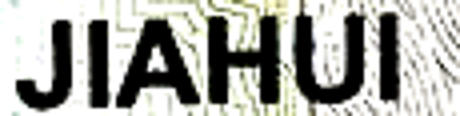

In [ ]:
cropped_images[8]

In [ ]:
pixel_values = processor(images=cropped_images[1], return_tensors="pt").pixel_values
# 4. Generate the text with adjustments (e.g., num_beams and early_stopping)
generated_ids = trocr_model.generate(
    pixel_values,
    num_beams=10,  # Increase beam width for better text accuracy
    max_new_tokens=4000,  # Adjust this based on expected text length
    early_stopping=True  # Stops when a full sentence is detected
)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

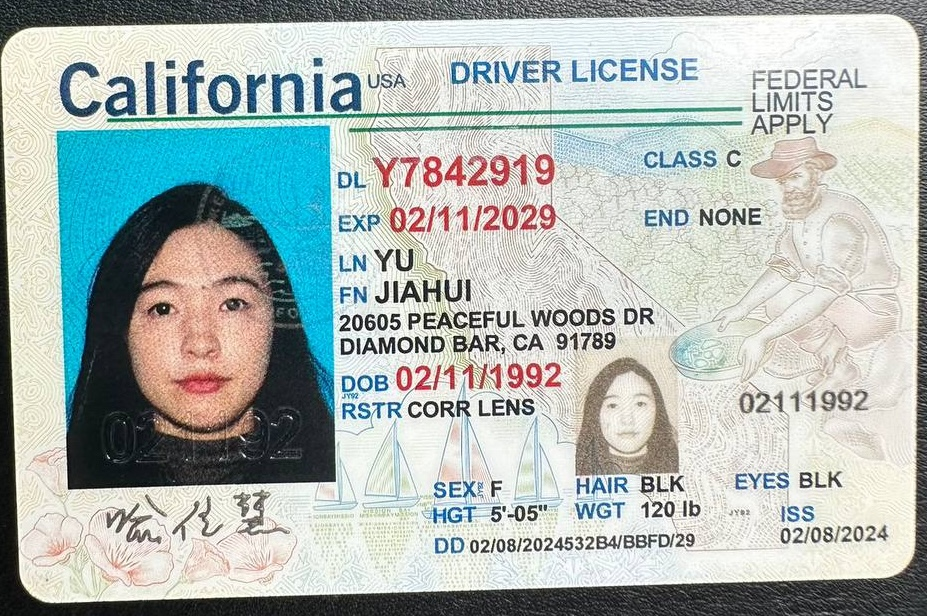

In [ ]:
# Move the model to the appropriate device before using it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rotate_model.to(device)

img = rotation(rotate_model, r'C:/Users/Union/Driving_License_OCR-main/demo/1.jpeg')
img

In [ ]:
# 3. Prepare the image for the model
pixel_values = processor(images=img_top, return_tensors="pt").pixel_values

# 4. Generate the text with adjustments (e.g., num_beams and early_stopping)
generated_ids = trocr_model.generate(
    pixel_values,
    num_beams=5,  # Increase beam width for better text accuracy
    max_new_tokens=1000,  # Adjust this based on expected text length
    early_stopping=True  # Stops when a full sentence is detected
)

# 5. Decode the generated text
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

# Output the text
print("Extracted Text:", generated_text)

Extracted Text: 617 60TH ST @


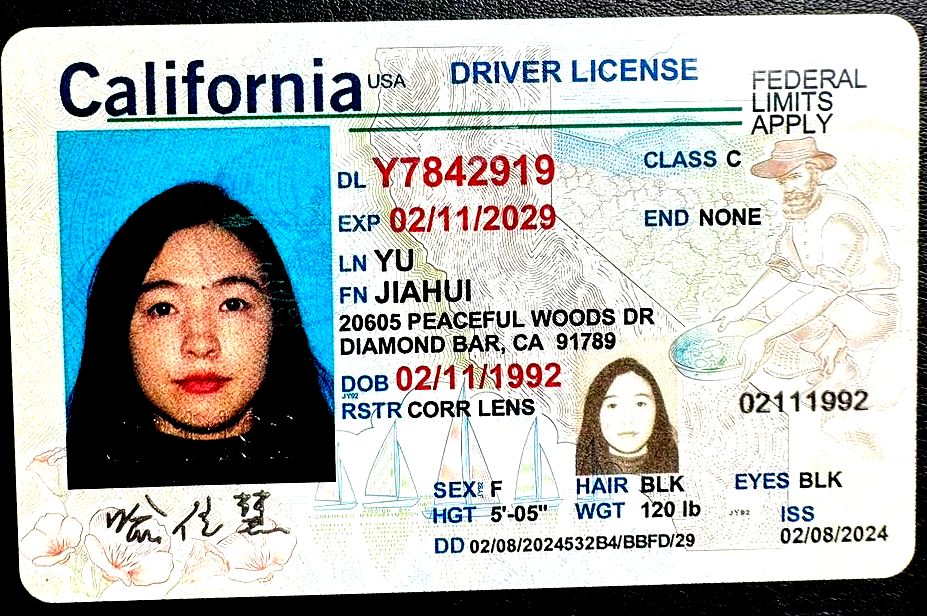

In [ ]:
import time
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# Load the processor and model
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

# Function to perform OCR
def perform_ocr(image, model, processor):
    pixel_values = processor(images=image, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

# Load an example image
image = ...  # Load your image here

# Measure performance without optimization
start_time = time.time()
text = perform_ocr(image, model, processor)
end_time = time.time()
print(f"Time without optimization: {end_time - start_time:.2f} seconds")

# Apply quantization
model = torch.quantization.quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)

# Measure performance with quantization
start_time = time.time()
text = perform_ocr(image, model, processor)
end_time = time.time()
print(f"Time with quantization: {end_time - start_time:.2f} seconds")


In [ ]:
from PIL import Image
import requests
from io import BytesIO

# Load the example image
url = r"https://upload.wikimedia.org/wikipedia/commons/thumb/4/4b/Handwritten_text_sample.jpg/800px-Handwritten_text_sample.jpg"
response = requests.get(url)
image = Image.open(BytesIO(response.content))

# Now you can use this image in the perform_ocr function
text = perform_ocr(image, model, processor)
print(f"Recognized text: {text}")


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x00000149E28C5440>